Logs
- [2025/04/16]    
  Some alternatives to MNIST
  - https://github.com/zalandoresearch/fashion-mnist
  - https://github.com/rois-codh/kmnist

- [2025/04/17]    
  To use tensorflowjs, we need to use specific version of tensorflow when
  training the model.   
  TensorFlow 2.15.0 and tfjs 4.22.0

- [2025/04/19]    
  Use `tfjs.converters.save_keras_model(model, "./recognition/models/")`  
  to save the model

- [2025/04/21]  
  Please install `tensorflow==2.15.0`   
  with `pip install tensorflow==2.15.0`

Instead using MNIST, here we use EMNIST (Extended MNIST)    
https://www.nist.gov/itl/products-and-services/emnist-dataset. 

And this notebook only processing `emnist-letters-*`

In [1]:
import gzip
import struct as st
import numpy as np
import tensorflow as tf
# import tensorflowjs as tfjs            # pip install tensorflowjs
import matplotlib.pyplot as plt
import time

2025-04-21 12:45:27.929905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 12:45:29.237059: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-04-21 12:45:31.033756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-21 12:45:31.093665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-21 12:45:31.093948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25,
  'figure.facecolor': 'white'})

From https://medium.com/the-owl/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1

IDX file format
```
magic number
size in dimension 0
size in dimension 1
...
size in dimension N
data
```

### Magic number
The magic number is an integer (MSB - Most Signficant Byte, first). The first
two bytes are always 0. 

The third byte codes the type of the data:
- 0x08: unsigned byte 
- 0x09: signed byte
- 0x0B: short (2 bytes)
- 0x0C: int (4 bytes)
- 0x0D: float (4 bytes)
- 0x0E: double (8 bytes)

The fourth bytes codes the number of dimensions of the vector/matrix/tensor:   
1 for vectors, 2 for matrix, 3 for tensor, and so on.

### Size in dimension
The sizes in each dimension are 4-byte integers (MSB first, high endian, like
in most non-Intel processors).

The data is stored like in a C array, i.e. the index in the last dimension changes 
the fastest

In [4]:
def read_idx_to_numpy(DIR_input, filename_dict, key, verbose=False):
  start_time = time.perf_counter()
  fdata = gzip.open(DIR_input + filename_dict[key])

  # -- read magic number
  # ">4B": Big endian, unsigned char four times = ">BBBB"
  # See: https://docs.python.org/3/library/struct.html#format-strings
  magic = st.unpack(">4B", fdata.read(4))
  if verbose: print(f"magic = {magic}")
  dtype_magic_num = {
    "8": [">B", np.uint8], "9": [">b", np.int8],
    "B": [">H", np.uint16], "C": [">h", np.int16],
    "D": [">I", np.uint32], "E": [">i", np.int32]}
  dtype_image = dtype_magic_num[f"{magic[2]}"]
  if verbose: print(f"data type = {dtype_image}")

  # -- read dimensions of the image dataset (size is stored in 4-bytes integers: I)
  size_dims = []
  for idx in range(magic[-1]):
    size_dims.append(st.unpack(">I", fdata.read(4))[0])
  if verbose: print(f"size_dim = {size_dims}")

  # -- read the image or label data 
  n_bytes_total = np.prod(size_dims)   # in byte
  if verbose: print(f"total bytes: {n_bytes_total:,}")
  format_char = dtype_image[0]
  data_array = np.array(st.unpack(format_char[0] + f"{n_bytes_total}" + format_char[1], 
    fdata.read(n_bytes_total)), dtype=dtype_image[1]).reshape(size_dims)
  
  if verbose: print(f"computational time: {time.perf_counter() - start_time:.2f} s")
  return data_array



read training data

In [5]:
DIR_input = "./emnist/"
train_filename = {"images": "emnist-letters-train-images-idx3-ubyte.gz",
                  "labels": "emnist-letters-train-labels-idx1-ubyte.gz"}
images_train = read_idx_to_numpy(DIR_input, train_filename, "images", verbose=True)
labels_train = read_idx_to_numpy(DIR_input, train_filename, "labels", verbose=True)

magic = (0, 0, 8, 3)
data type = ['>B', <class 'numpy.uint8'>]
size_dim = [124800, 28, 28]
total bytes: 97,843,200
computational time: 7.31 s
magic = (0, 0, 8, 1)
data type = ['>B', <class 'numpy.uint8'>]
size_dim = [124800]
total bytes: 124,800
computational time: 0.01 s


In [6]:
np.shape(images_train)

(124800, 28, 28)

read testing data

In [7]:
DIR_input = "./emnist/"
test_filename = {"images": "emnist-letters-test-images-idx3-ubyte.gz",
                 "labels": "emnist-letters-test-labels-idx1-ubyte.gz"}
images_test = read_idx_to_numpy(DIR_input, test_filename, "images", verbose=True)
labels_test = read_idx_to_numpy(DIR_input, test_filename, "labels", verbose=True)


magic = (0, 0, 8, 3)
data type = ['>B', <class 'numpy.uint8'>]
size_dim = [20800, 28, 28]
total bytes: 16,307,200
computational time: 1.42 s
magic = (0, 0, 8, 1)
data type = ['>B', <class 'numpy.uint8'>]
size_dim = [20800]
total bytes: 20,800
computational time: 0.00 s


read letter mapping 

In [8]:
letter_map = ["."]
with open("./emnist/emnist-letters-mapping.txt", "r") as fmapping:
  mapping_data = fmapping.readlines()
  for row in mapping_data:
    _, lower_ascii, upper_ascii = row.strip().split()
    letter_map.append(f"{chr(int(lower_ascii))}{chr(int(upper_ascii))}")
  
letter_map

['.',
 'Aa',
 'Bb',
 'Cc',
 'Dd',
 'Ee',
 'Ff',
 'Gg',
 'Hh',
 'Ii',
 'Jj',
 'Kk',
 'Ll',
 'Mm',
 'Nn',
 'Oo',
 'Pp',
 'Qq',
 'Rr',
 'Ss',
 'Tt',
 'Uu',
 'Vv',
 'Ww',
 'Xx',
 'Yy',
 'Zz']

Prepare data for training

In [9]:
x_train = images_train / 255.0
x_test = images_test / 255.0

x_train = x_train.reshape(
  x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = np.transpose(x_train, axes=[0, 2, 1, 3])
x_test = x_test.reshape(
  x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = np.transpose(x_test, axes=[0, 2, 1, 3])

y_train = tf.keras.utils.to_categorical(labels_train)
y_test = tf.keras.utils.to_categorical(labels_test)

In [10]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

Visualize training data

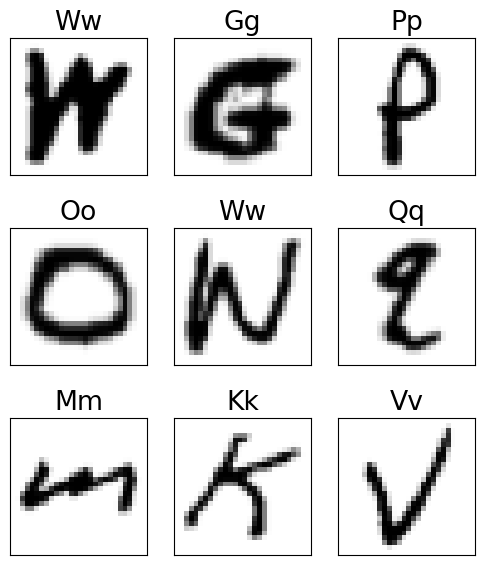

In [11]:
# less than a second
nrows = 3
ncols = 3

# 23 secs to show the images
# nrows = 10
# ncols = 10

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 7), 
                          sharex=True, sharey=True)


for idx in range(nrows*ncols):

  image = x_train[idx]
  axes[idx//ncols, idx%nrows].imshow(image, cmap="gray_r")

  axes[idx//ncols, idx%nrows].set_xticks([])
  axes[idx//ncols, idx%nrows].set_yticks([])
  axes[idx//ncols, idx%nrows].set_title(letter_map[labels_train[idx]])


plt.show(fig)

Visualize testing data

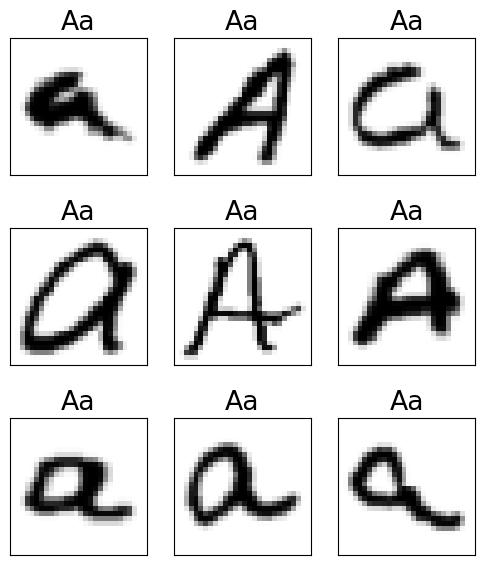

In [12]:
# less than a second
nrows = 3
ncols = 3

# 23 secs to show the images
# nrows = 10
# ncols = 10

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6, 7), 
                          sharex=True, sharey=True)


for idx in range(nrows*ncols):

  image = x_test[idx]
  axes[idx//ncols, idx%nrows].imshow(image, cmap="gray_r")

  axes[idx//ncols, idx%nrows].set_xticks([])
  axes[idx//ncols, idx%nrows].set_yticks([])
  axes[idx//ncols, idx%nrows].set_title(letter_map[labels_test[idx]])


plt.show(fig)

Create a convolutional neural network

In [13]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Input((28, 28, 1)),

  # Convolutional layer. Learn 32 filters using a 3x3 kernel
  tf.keras.layers.Conv2D(
    32, (3, 3), activation="relu"),

  # Max-pooling layer, using 2x2 pool size
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Flatten units
  tf.keras.layers.Flatten(),

  # Add hidden layer with dropout
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.5),

  # Add an output layer with output units for all 26 letters
  tf.keras.layers.Dense(27, activation="softmax")
])

2025-04-21 12:45:50.816429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-21 12:45:50.816771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-21 12:45:50.816990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                3483      
                                                        

Train neural networks

In [15]:
model.compile(
  optimizer="adam",
  loss="categorical_crossentropy",
  metrics=["accuracy"]
)

history = model.fit(x_train, y_train, epochs=10)

Epoch 1/10


2025-04-21 12:45:56.830783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-04-21 12:45:59.580500: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4664da3960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-21 12:45:59.580541: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-04-21 12:46:01.902798: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-21 12:46:18.343657: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3900/3900 [==============================] - 38s 3ms/step - loss: 0.8858 - accuracy: 0.7301
Epoch 2/10
3900/3900 [==============================] - 14s 4ms/step - loss: 0.5393 - accuracy: 0.8294
Epoch 3/10
3900/3900 [==============================] - 14s 3ms/step - loss: 0.4557 - accuracy: 0.8540
Epoch 4/10
3900/3900 [==============================] - 14s 3ms/step - loss: 0.4114 - accuracy: 0.8679
Epoch 5/10
3900/3900 [==============================] - 13s 3ms/step - loss: 0.3785 - accuracy: 0.8774
Epoch 6/10
3900/3900 [==============================] - 13s 3ms/step - loss: 0.3538 - accuracy: 0.8839
Epoch 7/10
3900/3900 [==============================] - 13s 3ms/step - loss: 0.3352 - accuracy: 0.8902
Epoch 8/10
3900/3900 [==============================] - 13s 3ms/step - loss: 0.3160 - accuracy: 0.8957
Epoch 9/10
3900/3900 [==============================] - 13s 3ms/step - loss: 0.3032 - accuracy: 0.8991
Epoch 10/10
3900/3900 [==============================] - 13s 3ms/step - loss: 0.2900

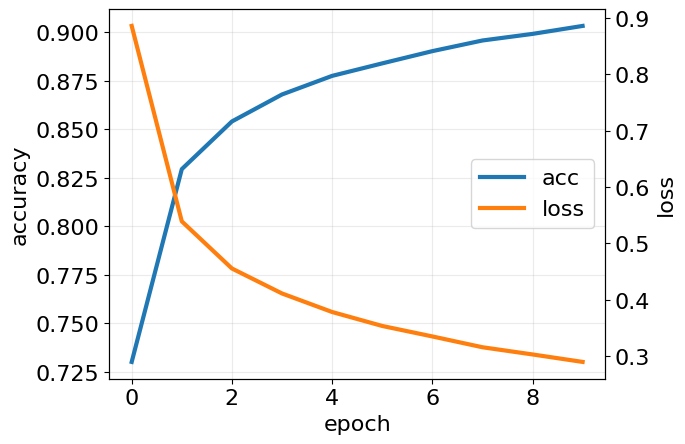

In [16]:
acc = history.history["accuracy"]
loss = history.history["loss"]

fig, ax = plt.subplots()

ax.plot(acc, label="acc", linewidth=3)
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.grid("on")

ax_right = ax.twinx()
ax_right.plot(loss, color="tab:orange", label="loss", linewidth=3)
ax_right.set_ylabel("loss")

handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_ax_right, labels_ax_right = ax_right.get_legend_handles_labels()
handles = handles_ax + handles_ax_right
labels = labels_ax + labels_ax_right
ax.legend(handles, labels, loc="center right")

plt.show(fig)

Evaluate neural network performance

In [17]:
model.evaluate(x_test, y_test, verbose=2)

650/650 - 1s - loss: 0.2591 - accuracy: 0.9245 - 1s/epoch - 2ms/step


[0.2591310143470764, 0.9245192408561707]

Save model to file

In [18]:
# tfjs.converters.save_keras_model(model, "../00-demo/recognition/models/")

In [19]:
# model.save("handwriting-letters.keras")